#Cloud and environment 2019 final report and code
##1. pm2.5 data selection
##2. define pollution and Clustering pollution events
##3. Evaluating  pollution events prediction model (an Generalized linear model) by using pca results from CFSR data as the model features
##4. Predict the pollution events using the mri data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ['PROJ_LIB'] = 'D:\\program\\anaconda3\\Library\\share\\'
from mpl_toolkits.basemap import Basemap
# For Chinese font
from matplotlib.font_manager import FontProperties
from sklearn import preprocessing
import time
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.feature_selection import RFECV
font = FontProperties(fname="NotoSansCJKtc-Regular.otf", size=10)
data = pd.read_csv('pm25_2000_2014.csv')
data2015 = pd.read_csv('pm25_2015.csv')

def show_cfsr_array(data, title=None):
    # Read data
    tmp = data
    # Create Basemap for CFSR
    lons = np.linspace(114.5, 128., num=tmp.shape[1])
    lats = np.linspace(18., 29.5, num=tmp.shape[0])
    x, y = np.meshgrid(lons,lats)
    m = Basemap(llcrnrlon=114.5, urcrnrlon=128., llcrnrlat=18., urcrnrlat=29.5)
    # draw coastlines, state and country boundaries, edge of map.
    m.drawcoastlines()
    m.contourf(x, y, tmp, 30, cmap=plt.cm.jet)
    m.colorbar()
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    return(0)

In [2]:
pm25 = data.iloc[:,2:]
pm25.index = data['date']+':'+data['hour']
pm25.head()
#there are too less stations have pm2.5 observation between 2000 and 2005

,嘉義,龍潭,淡水,湖口,苗栗,美濃,大園,前鎮,基隆,板橋,...,陽明,善化,萬里,三重,新營,斗六,中山,新港,安南,林園
2000-01-01:h00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,26.03,NaN,NaN,NaN,NaN,NaN,68.83
2000-01-01:h01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.79,NaN,NaN,NaN,NaN,NaN,96.83
2000-01-01:h02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,23.14,NaN,NaN,NaN,NaN,NaN,125.97
2000-01-01:h03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,23.94,NaN,NaN,NaN,NaN,NaN,125.60
2000-01-01:h04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,17.14,NaN,NaN,NaN,NaN,NaN,118.23


###air pollution selected range

Most of stations lack pm2.5 observation over the year before 2006, so all data using in the report are selected from 2006 to 2015. The selection of the station is limited to 68 stations to make sure that every station have relative continued oberservation of pm2.5 during selected period.

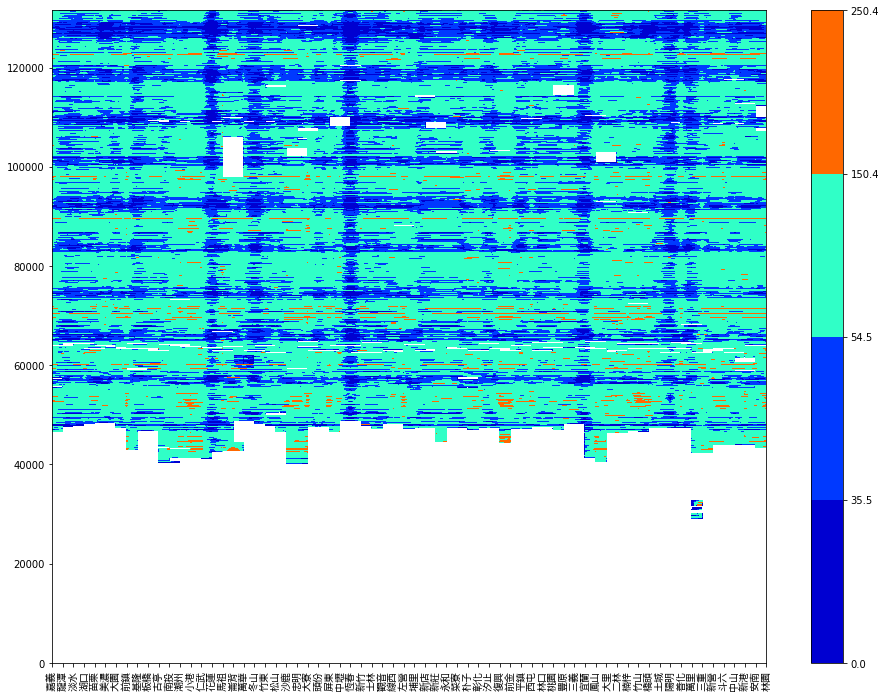

In [3]:
plt.figure(figsize=(16,12))
plt.contourf(pm25.values[:], levels=[0, 35.5, 54.5, 150.4, 250.4], cmap='jet')
station00_14=list(pm25.columns)
plt.xticks(np.arange(0,68,step=1),station00_14[0:68], rotation=90, fontproperties=font)
plt.colorbar()
plt.show()

In [4]:
print(station00_14)
pm2506 = data.values[52608:131496,2:]


['嘉義', '龍潭', '淡水', '湖口', '苗栗', '美濃', '大園', '前鎮', '基隆', '板橋', '古亭', '南投', '潮州', '小港', '仁武', '花蓮', '馬祖', '崙背', '萬華', '冬山', '竹東', '松山', '沙鹿', '忠明', '大寮', '頭份', '屏東', '中壢', '恆春', '新竹', '士林', '觀音', '線西', '左營', '埔里', '新店', '新莊', '永和', '菜寮', '朴子', '彰化', '汐止', '復興', '前金', '平鎮', '西屯', '林口', '桃園', '豐原', '三義', '宜蘭', '鳳山', '大里', '二林', '楠梓', '竹山', '橋頭', '土城', '陽明', '善化', '萬里', '三重', '新營', '斗六', '中山', '新港', '安南', '林園']


In [5]:
pmleft = np.empty((87648,68))
pmleft[:,:] = np.nan
pmleft[0:78888,:] = pm2506[:,:]

leftdate = [0]*87648
aaa=list(pm25.index)
leftdate[0:78888] = aaa[52608:131496]

In [6]:
col2015= list(data2015.columns)

date2015 = [0]*8760
from datetime import datetime, timedelta  
testdate = data2015['date']
#print(testdate.head)
for i in range(0,8760):
 aa = datetime.strptime(testdate[i],'%Y/%m/%d')

 traa = datetime.strftime(aa,'%Y-%m-%d')
 date2015[i]=traa
#print(date2015)
pm2015 = data2015.iloc[:,0]
outdate2015=pd.DataFrame(date2015,columns=['date'])
pm2015.index = outdate2015['date']+':'+data2015['hour']
aaaa2015=list(pm2015.index)
#print(aaaa2015)
leftdate[78888:87648] = aaaa2015
#aaa = datetime.strftime(newdate,'%d%b%Y')

In [7]:
for i in range(0,78):
    for j in range(0,68):
          if col2015[i] in station00_14[j]:
                   pmleft[78888:87648,j] = data2015.values[:,i]

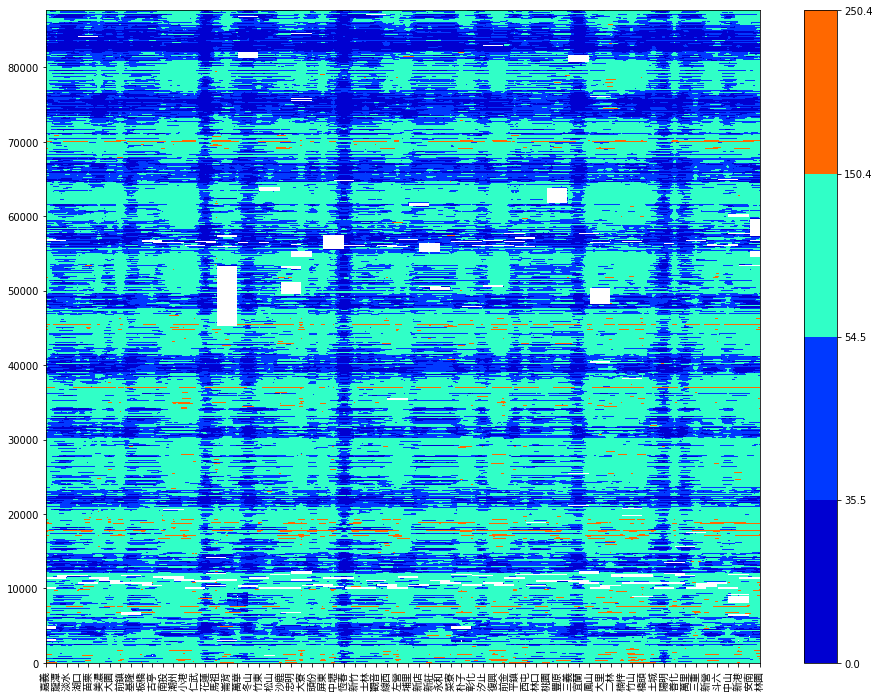

In [8]:
fig = plt.figure(figsize=(16,12))
plt.contourf(pmleft,levels=[0, 35.5, 54.5, 150.4, 250.4], cmap='jet')
plt.xticks(np.arange(0,68,step=1),station00_14[0:68], rotation=90, fontproperties=font)
plt.colorbar()
plt.show()

In [10]:
outputpm=pd.DataFrame(pmleft,index=leftdate,columns=station00_14)
pm_ma24 = outputpm.rolling(24).mean()
outputpm.head()

,嘉義,龍潭,淡水,湖口,苗栗,美濃,大園,前鎮,基隆,板橋,...,陽明,善化,萬里,三重,新營,斗六,中山,新港,安南,林園
2006-01-01:h00,18.0,10.0,8.0,14.0,14.0,38.0,11.0,63.0,13.0,35.0,...,4.0,17.0,13.0,25.0,22.0,37.0,22.0,20.0,25.0,69.0
2006-01-01:h01,25.0,10.0,10.0,11.0,18.0,39.0,23.0,60.0,13.0,38.0,...,5.0,20.0,17.0,12.0,24.0,32.0,16.0,18.0,19.0,62.0
2006-01-01:h02,25.0,13.0,12.0,12.0,17.0,35.0,26.0,59.0,13.0,17.0,...,5.0,16.0,19.0,23.0,26.0,28.0,23.0,18.0,25.0,63.0
2006-01-01:h03,28.0,16.0,14.0,16.0,17.0,31.0,14.0,63.0,11.0,15.0,...,6.0,24.0,17.0,12.0,24.0,21.0,23.0,31.0,26.0,66.0
2006-01-01:h04,23.0,19.0,13.0,17.0,18.0,37.0,29.0,59.0,14.0,12.0,...,5.0,19.0,18.0,12.0,27.0,21.0,28.0,26.0,28.0,64.0


In [11]:
 # Function to compute summed air-pollution-index and cut the whole series with specified time window
def api_timeseries(outputpm, threshold=54.5, window=240):
    tmp = (outputpm>=threshold)*1
    tmp = tmp.sum(axis=1)
    ts = {}
    for i in np.arange(23+window, len(tmp), 24):
        #print('Index: '+str(i-window)+' ~ '+str(i))
        ts[tmp.index[i]] = list(tmp[i-window:i])
    df = pd.DataFrame(ts)
    return(df)

apts = api_timeseries(pm_ma24)
apts.head()

,2006-01-11:h23,2006-01-12:h23,2006-01-13:h23,2006-01-14:h23,2006-01-15:h23,2006-01-16:h23,2006-01-17:h23,2006-01-18:h23,2006-01-19:h23,2006-01-20:h23,...,2015-12-22:h23,2015-12-23:h23,2015-12-24:h23,2015-12-25:h23,2015-12-26:h23,2015-12-27:h23,2015-12-28:h23,2015-12-29:h23,2015-12-30:h23,2015-12-31:h23
0,8,13,42,48,18,1,10,14,10,12,...,0,0,0,7,49,3,0,0,1,3
1,8,14,43,48,16,1,10,14,10,12,...,0,0,0,8,47,3,0,0,1,2
2,8,14,42,48,14,1,10,14,11,12,...,0,0,0,11,45,2,0,0,1,1
3,8,14,43,48,13,1,10,14,11,12,...,0,0,0,15,40,2,0,0,1,1
4,8,15,42,47,13,2,10,14,11,13,...,0,0,0,19,35,1,0,0,1,1


###Clustering air pollution events into three types

[ 773 1256 1613]


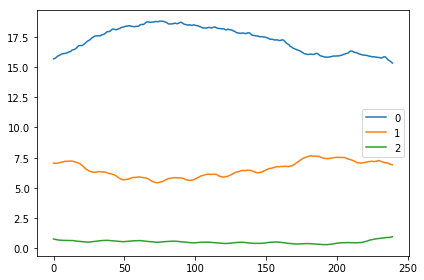

In [12]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import linear_model
ncluster = 3
data11 = apts
hc = AgglomerativeClustering(n_clusters=ncluster, affinity='euclidean', linkage='ward')  
hc.fit_predict(data11.T) 

print(np.bincount(hc.labels_))
#print(hc.labels_)

for i in range(ncluster):
    plt.plot(data11.iloc[:,hc.labels_==i].mean(axis=1),label=i)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
YY = (hc.labels_==0)*1
YY = np.array(YY).flatten()
print(YY.shape)

(3642,)


In [14]:
allrh850 = pd.read_csv('tw_h500_0705.csv')
from sklearn.decomposition import PCA
forpca= allrh850.iloc[:,1:]
print(forpca.shape)
pca = PCA(n_components=200)                                  # Initialize a PCA with 10 PCs
pca.fit(forpca)                                               # Calculate PCA
projh500 = pca.transform(forpca)

(3642, 6720)


In [85]:
allrh850 = pd.read_csv('tw_th850_0705.csv')
from sklearn.decomposition import PCA
forpca= allrh850.iloc[:,1:]
print(forpca.shape)
pca_th850 = PCA(n_components=200)                                  # Initialize a PCA with 10 PCs
pca_th850.fit(forpca)                                               # Calculate PCA
projth850 = pca.transform(forpca)

(3642, 6720)


###CFSR
###theta e 850 PC1

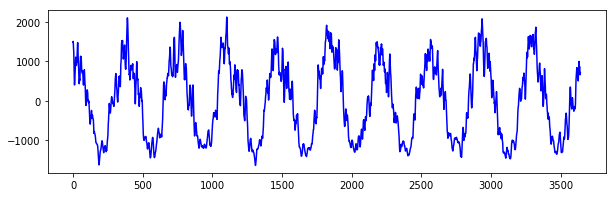

In [86]:
plt.figure(figsize=(10,3))
plt.plot(projth850[:3642,0],'b-')

###CFSR
###theta e 850 PC10

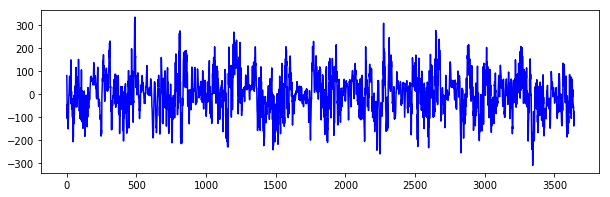

In [87]:
plt.figure(figsize=(10,3))
plt.plot(projth850[:3642,9],'b-')

In [88]:
allrh850 = pd.read_csv('tw_mri_th850_0705.csv')

mri= allrh850.iloc[:,1:]
print(mri.shape)
mri_pca_th850 = pca_th850.transform(mri)
print(mri_pca_th850.shape)

(3642, 6720)
(3642, 200)


###MRI
###theta e 850 PC1

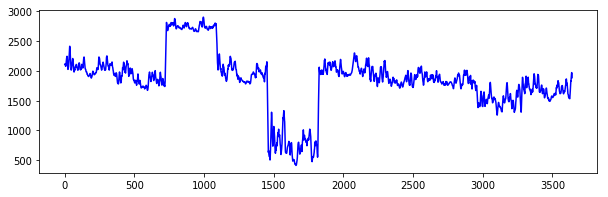

In [89]:
plt.figure(figsize=(10,3))
plt.plot(mri_pca_th850[:3642,0], 'b-')

###MRI
###theta e 850 PC10

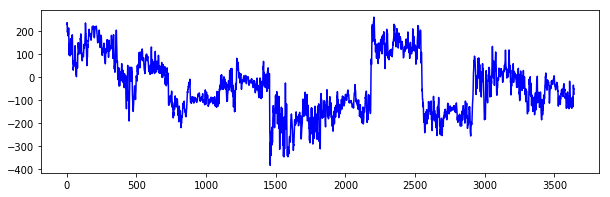

In [90]:
plt.figure(figsize=(10,3))
plt.plot(mri_pca_th850[:3642,9], 'b-')

In [105]:
allrh850 = pd.read_csv('tw_th700_0705.csv')
from sklearn.decomposition import PCA
forpca= allrh850.iloc[:,1:]
print(forpca.shape)
pca_th700 = PCA(n_components=200)                                  # Initialize a PCA with 10 PCs
pca_th700.fit(forpca)                                               # Calculate PCA
projth700 = pca.transform(forpca)

(3642, 6720)


###CFSR
###theta e 700 PC1

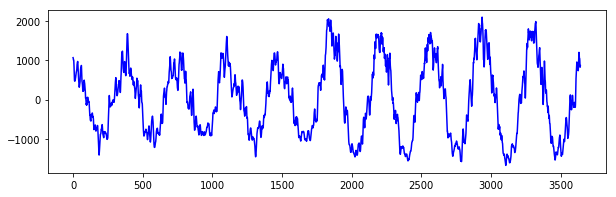

In [106]:
plt.figure(figsize=(10,3))
plt.plot(projth700[:3642,0],'b-')

###CFSR
###theta e 700 PC2

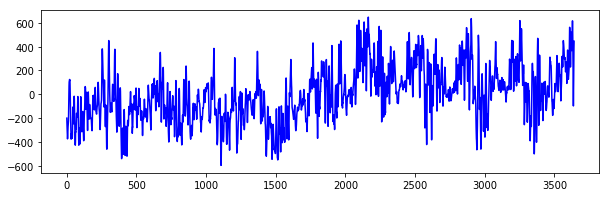

In [107]:
plt.figure(figsize=(10,3))
plt.plot(projth700[:3642,1],'b-')

In [108]:
allrh850 = pd.read_csv('tw_mri_th700_0705.csv')

mri= allrh850.iloc[:,1:]
print(mri.shape)
mri_pca_th700 = pca_th700.transform(mri)
print(mri_pca_th700.shape)

(3642, 6720)
(3642, 200)


###MRI
###theta e 700 PC1

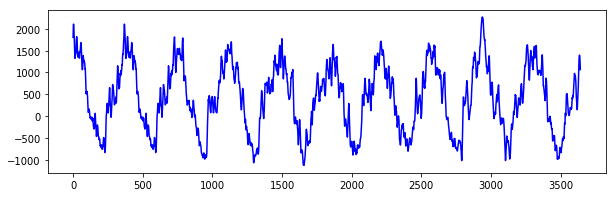

In [109]:
plt.figure(figsize=(10,3))
plt.plot(mri_pca_th700[:3642,0], 'b-')

###MRI
###theta e 700 PC2

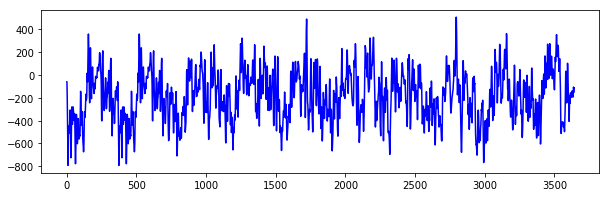

In [110]:
plt.figure(figsize=(10,3))
plt.plot(mri_pca_th700[:3642,1], 'b-')

In [36]:
nor_h500 = preprocessing.scale(projh500,axis=0)
nor_th700 = preprocessing.scale(projth700,axis=0)
nor_th850 = preprocessing.scale(projth850,axis=0)

nor_mri_th850 = preprocessing.scale(mri_pca_th850,axis=0)
nor_mri_th700 = preprocessing.scale(mri_pca_th700,axis=0)

In [37]:
akk=np.empty((3642,120))

akk[:,0:40] = nor_h500[0:3642,0:40]

akk[:,40:80] = nor_th850[0:3642,0:40]
akk[:,80:120] = nor_th700[0:3642,0:40]
akk_mri=np.empty((3642,4))
#akk_mri[:,0] = nor_mri[0:3642,0]

### Using 2006~2013's data to train the GLM model
### Using trained model to predict 2014 and 2015's air pollution events

In [38]:
# Split data into training and testing: 2005~2013 for training, and 2014 for testing
x_test = np.array(akk[2912:,:])
y_test = np.array(YY[2912:,])
X = np.array(akk[:2912,:])
Y = np.array(YY[:2912,])

#
print('Data dimension: ')
print('    Training set: ')
print(X.shape)
print(Y.shape)
print('    Test set: ')
print(x_test.shape)
print(y_test.shape)
print()


# Metrics function for reuse
def evaluate_model(y_true, y_pred):
    # Create confusion matrix
    cfm = pd.crosstab(y_true, y_pred, rownames=['Truth'], colnames=['Prediction'])
    # Create report
    from sklearn.metrics import accuracy_score, classification_report
    cr = classification_report(y_true, y_pred)
    return({'matrix':cfm, 'report':cr})

Data dimension: 
    Training set: 
(2912, 120)
(2912,)
    Test set: 
(730, 120)
(730,)



In [39]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

sp = SelectPercentile(mutual_info_classif, percentile=60)
sp.fit(X, Y)
newx = sp.transform(X)
print(newx.shape)

# Fit the classifier
glm = LogisticRegression(C=1e5, solver='lbfgs', max_iter=500)
glm.fit(newx, Y)
yhat = glm.predict(newx)

# Show results on training data
cfm = evaluate_model(Y, yhat)
print(cfm['matrix'])
print()
print(cfm['report'])

# Show results on test data
newx_test = sp.transform(x_test)
yhat = glm.predict(newx_test)
cfm = evaluate_model(y_test, yhat)
print(cfm['matrix'])
print()
print(cfm['report'])

(2912, 72)
Prediction     0    1
Truth                
0           2002  183
1            333  394

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      2185
           1       0.68      0.54      0.60       727

   micro avg       0.82      0.82      0.82      2912
   macro avg       0.77      0.73      0.75      2912
weighted avg       0.81      0.82      0.82      2912

Prediction    0   1
Truth              
0           594  90
1             2  44

              precision    recall  f1-score   support

           0       1.00      0.87      0.93       684
           1       0.33      0.96      0.49        46

   micro avg       0.87      0.87      0.87       730
   macro avg       0.66      0.91      0.71       730
weighted avg       0.95      0.87      0.90       730



In [40]:
y_test = np.array(YY[:,])

X = np.array(akk[:,:])
Y = np.array(YY[:,])

### pick the best features to train a new model

select 4 features:

Theta e 850 PC1 and PC10

Theta e 700 PC1 and PC2


Optimal number of features : 4


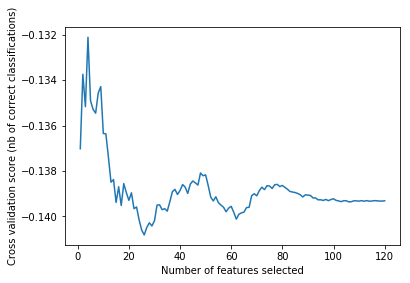

In [41]:
# Reference: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score.
glm = LogisticRegression(C=1e5, solver='lbfgs', max_iter=500)
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=glm, step=1, cv=StratifiedKFold(5), scoring='brier_score_loss')
rfecv.fit(X, Y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [42]:
print(rfecv.support_)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


In [43]:
x_test = np.array(akk[2912:,:])
y_test = np.array(YY[2912:,])
X = np.array(akk[:2912,:])
Y = np.array(YY[:2912,])


In [44]:
x_rfe_sele=np.empty((2912,4))
x_test_rfe_sele=np.empty((730,4))
x_rfe_sele[:,0] = akk[:2912,40]
x_rfe_sele[:,1] = akk[:2912,49]
x_rfe_sele[:,2] = akk[:2912,80]
x_rfe_sele[:,3] = akk[:2912,81]

x_test_rfe_sele[:,0] = akk[2912:,40]
x_test_rfe_sele[:,1] = akk[2912:,49]
x_test_rfe_sele[:,2] = akk[2912:,80]
x_test_rfe_sele[:,3] = akk[2912:,81]


### Based on 4 selected features
###Using 2006~2013's data to train the GLM model
###Using trained model to predict 2014 and 2015's air pollution events

The results show that trained model can predict 45% air pollution events on training data and can predict 74% air pollution events on testing data.

In [45]:

print(x_rfe_sele.shape)
print(x_test_rfe_sele.shape)
# Fit the classifier
glm = LogisticRegression(C=1e5, solver='lbfgs', max_iter=500)
glm.fit(x_rfe_sele, Y)
yhat = glm.predict(x_rfe_sele)

# Show results on training set
cfm = evaluate_model(Y, yhat)
print(cfm['matrix'])
print()
print(cfm['report'])

# Show results on test set
yhat = glm.predict(x_test_rfe_sele)
cfm = evaluate_model(y_test, yhat)
print(cfm['matrix'])
print()
print(cfm['report'])

(2912, 4)
(730, 4)
Prediction     0    1
Truth                
0           1977  208
1            399  328

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      2185
           1       0.61      0.45      0.52       727

   micro avg       0.79      0.79      0.79      2912
   macro avg       0.72      0.68      0.69      2912
weighted avg       0.78      0.79      0.78      2912

Prediction    0   1
Truth              
0           612  72
1            12  34

              precision    recall  f1-score   support

           0       0.98      0.89      0.94       684
           1       0.32      0.74      0.45        46

   micro avg       0.88      0.88      0.88       730
   macro avg       0.65      0.82      0.69       730
weighted avg       0.94      0.88      0.91       730



In [46]:
x_rfe_sele=np.empty((3642,4))
x_test_rfe_sele=np.empty((3642,4))
x_rfe_sele[:,0] = akk[:,40]
x_rfe_sele[:,1] = akk[:,49]
x_rfe_sele[:,2] = akk[:,80]
x_rfe_sele[:,3] = akk[:,81]

x_test_rfe_sele[:,0] = nor_mri_th850[:,40]
x_test_rfe_sele[:,1] = nor_mri_th850[:,49]
x_test_rfe_sele[:,2] = nor_mri_th700[:,80]
x_test_rfe_sele[:,3] = nor_mri_th700[:,81]


y_test = np.array(YY[:,])
Y = np.array(YY[:,])



###Based on 4 selected features

###Using CFSR data to train the GLM model

###Using MRI data to predict air pollution events

In [47]:
print(x_rfe_sele.shape)
print(x_test_rfe_sele.shape)
# Fit the classifier
glm = LogisticRegression(C=1e5, solver='lbfgs', max_iter=500)
glm.fit(x_rfe_sele, Y)
yhat = glm.predict(x_rfe_sele)
ori=yhat
# Show results on training set
cfm = evaluate_model(Y, yhat)
print(cfm['matrix'])
print()
print(cfm['report'])

# Show results on test set
yhat = glm.predict(x_test_rfe_sele)
cfm = evaluate_model(y_test, yhat)
print(cfm['matrix'])
print()
print(cfm['report'])

(3642, 4)
(3642, 4)
Prediction     0    1
Truth                
0           2647  222
1            466  307

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      2869
           1       0.58      0.40      0.47       773

   micro avg       0.81      0.81      0.81      3642
   macro avg       0.72      0.66      0.68      3642
weighted avg       0.79      0.81      0.80      3642

Prediction     0    1
Truth                
0           2218  651
1            626  147

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      2869
           1       0.18      0.19      0.19       773

   micro avg       0.65      0.65      0.65      3642
   macro avg       0.48      0.48      0.48      3642
weighted avg       0.65      0.65      0.65      3642



###map of theta 850 and 700 PCs in different prediction scenarios

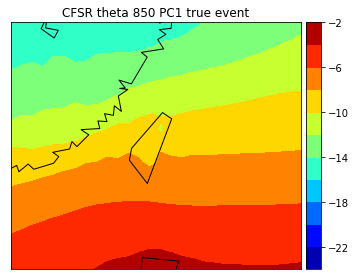

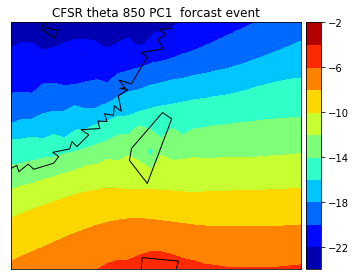

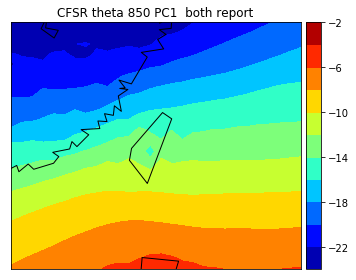

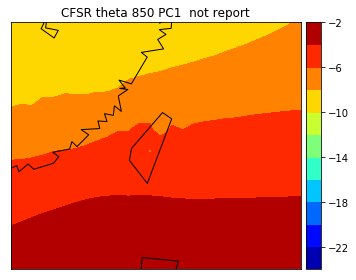

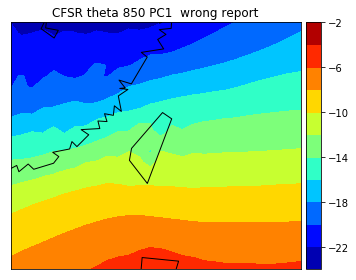

0

In [133]:
vector=projth850[0:3642,0]
pc1map=np.empty((3642,6720))
for i in range(0,3642):
 pc1map[i,:]=vector[i,]*pca_th850.components_[0]


def show_cfsr_array(data, title=None):
    # Read data
    tmp = data
    # Create Basemap for CFSR
    lons = np.linspace(114.5, 128., num=tmp.shape[1])
    lats = np.linspace(18., 29.5, num=tmp.shape[0])
    x, y = np.meshgrid(lons,lats)
    m = Basemap(llcrnrlon=114.5, urcrnrlon=128., llcrnrlat=18., urcrnrlat=29.5)
    # draw coastlines, state and country boundaries, edge of map.
    m.drawcoastlines()
    m.contourf(x, y, tmp, 30, levels=np.linspace(-24,-2,12),cmap=plt.cm.jet)
    m.colorbar()
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    return(0)



show_cfsr_array(pc1map[Y==1,:672].mean(axis=0).reshape(24,28), 'CFSR theta 850 PC1 true event')
show_cfsr_array(pc1map[ori==1,:672].mean(axis=0).reshape(24,28), 'CFSR theta 850 PC1  forcast event')
show_cfsr_array(pc1map[((Y==1) & (ori==1)),:672].mean(axis=0).reshape(24,28), 'CFSR theta 850 PC1  both report')
show_cfsr_array(pc1map[((Y==1) & (ori==0)),:672].mean(axis=0).reshape(24,28), 'CFSR theta 850 PC1  not report')
show_cfsr_array(pc1map[((Y==0) & (ori==1)),:672].mean(axis=0).reshape(24,28), 'CFSR theta 850 PC1  wrong report')

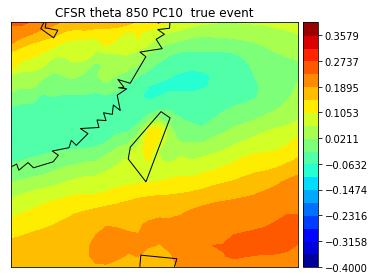

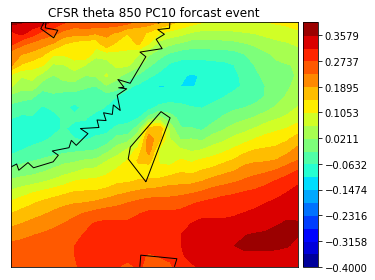

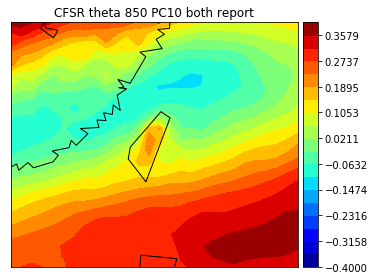

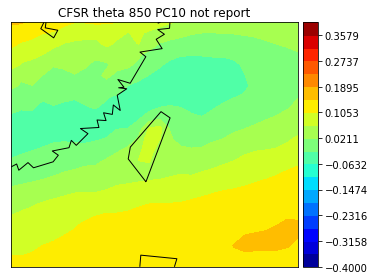

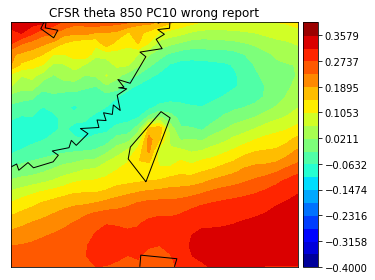

0

In [134]:
vector=projth850[0:3642,9]
pc1map=np.empty((3642,6720))
for i in range(0,3642):
 pc1map[i,:]=vector[i,]*pca_th850.components_[9]



def show_cfsr_array(data, title=None):
    # Read data
    tmp = data
    # Create Basemap for CFSR
    lons = np.linspace(114.5, 128., num=tmp.shape[1])
    lats = np.linspace(18., 29.5, num=tmp.shape[0])
    x, y = np.meshgrid(lons,lats)
    m = Basemap(llcrnrlon=114.5, urcrnrlon=128., llcrnrlat=18., urcrnrlat=29.5)
    # draw coastlines, state and country boundaries, edge of map.
    m.drawcoastlines()
    m.contourf(x, y, tmp, 30, levels=np.linspace(-0.4,0.4,20),cmap=plt.cm.jet)
    m.colorbar()
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    return(0)


show_cfsr_array(pc1map[Y==1,:672].mean(axis=0).reshape(24,28), 'CFSR theta 850 PC10  true event')
show_cfsr_array(pc1map[ori==1,:672].mean(axis=0).reshape(24,28), 'CFSR theta 850 PC10 forcast event')
show_cfsr_array(pc1map[((Y==1) & (ori==1)),:672].mean(axis=0).reshape(24,28), 'CFSR theta 850 PC10 both report')
show_cfsr_array(pc1map[((Y==1) & (ori==0)),:672].mean(axis=0).reshape(24,28), 'CFSR theta 850 PC10 not report')
show_cfsr_array(pc1map[((Y==0) & (ori==1)),:672].mean(axis=0).reshape(24,28), 'CFSR theta 850 PC10 wrong report')

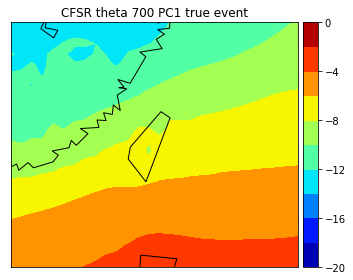

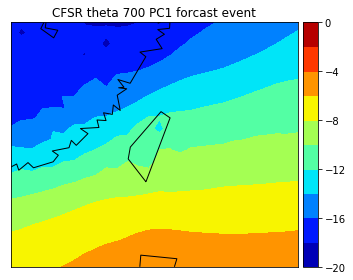

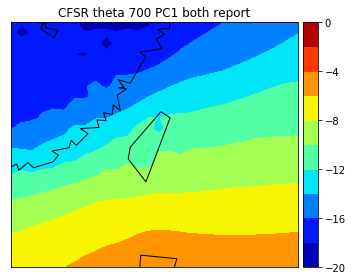

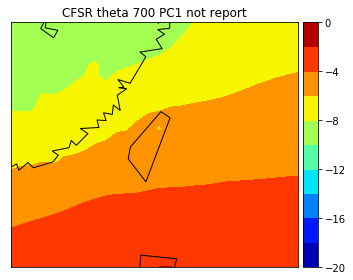

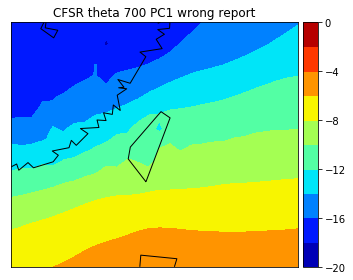

0

In [135]:
vector=projth700[0:3642,0]
pc1map=np.empty((3642,6720))
for i in range(0,3642):
 pc1map[i,:]=vector[i,]*pca_th700.components_[0]


def show_cfsr_array(data, title=None):
    # Read data
    tmp = data
    # Create Basemap for CFSR
    lons = np.linspace(114.5, 128., num=tmp.shape[1])
    lats = np.linspace(18., 29.5, num=tmp.shape[0])
    x, y = np.meshgrid(lons,lats)
    m = Basemap(llcrnrlon=114.5, urcrnrlon=128., llcrnrlat=18., urcrnrlat=29.5)
    # draw coastlines, state and country boundaries, edge of map.
    m.drawcoastlines()
    m.contourf(x, y, tmp, 30, levels=np.linspace(-20,0,11),cmap=plt.cm.jet)
    m.colorbar()
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    return(0)




show_cfsr_array(pc1map[Y==1,:672].mean(axis=0).reshape(24,28), 'CFSR theta 700 PC1 true event')
show_cfsr_array(pc1map[ori==1,:672].mean(axis=0).reshape(24,28), 'CFSR theta 700 PC1 forcast event')
show_cfsr_array(pc1map[((Y==1) & (ori==1)),:672].mean(axis=0).reshape(24,28), 'CFSR theta 700 PC1 both report')
show_cfsr_array(pc1map[((Y==1) & (ori==0)),:672].mean(axis=0).reshape(24,28), 'CFSR theta 700 PC1 not report')
show_cfsr_array(pc1map[((Y==0) & (ori==1)),:672].mean(axis=0).reshape(24,28), 'CFSR theta 700 PC1 wrong report')

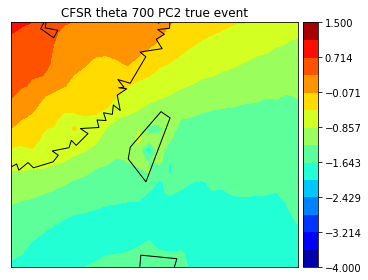

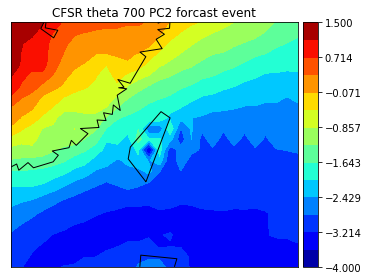

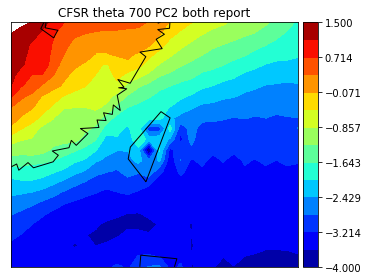

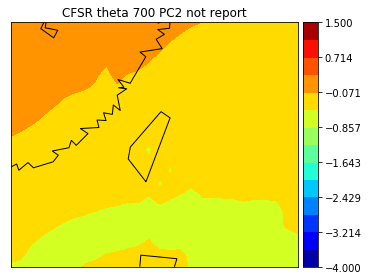

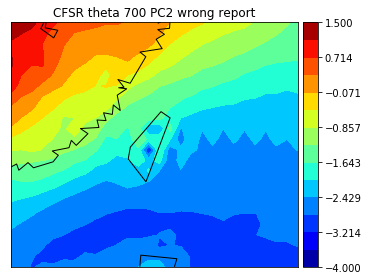

0

In [136]:
vector=projth700[0:3642,1]
pc1map=np.empty((3642,6720))
for i in range(0,3642):
 pc1map[i,:]=vector[i,]*pca_th700.components_[1]


def show_cfsr_array(data, title=None):
    # Read data
    tmp = data
    # Create Basemap for CFSR
    lons = np.linspace(114.5, 128., num=tmp.shape[1])
    lats = np.linspace(18., 29.5, num=tmp.shape[0])
    x, y = np.meshgrid(lons,lats)
    m = Basemap(llcrnrlon=114.5, urcrnrlon=128., llcrnrlat=18., urcrnrlat=29.5)
    # draw coastlines, state and country boundaries, edge of map.
    m.drawcoastlines()
    m.contourf(x, y, tmp, 30, levels=np.linspace(-4,1.5,15),cmap=plt.cm.jet)
    m.colorbar()
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    return(0)




show_cfsr_array(pc1map[Y==1,:672].mean(axis=0).reshape(24,28), 'CFSR theta 700 PC2 true event')
show_cfsr_array(pc1map[ori==1,:672].mean(axis=0).reshape(24,28), 'CFSR theta 700 PC2 forcast event')
show_cfsr_array(pc1map[((Y==1) & (ori==1)),:672].mean(axis=0).reshape(24,28), 'CFSR theta 700 PC2 both report')
show_cfsr_array(pc1map[((Y==1) & (ori==0)),:672].mean(axis=0).reshape(24,28), 'CFSR theta 700 PC2 not report')
show_cfsr_array(pc1map[((Y==0) & (ori==1)),:672].mean(axis=0).reshape(24,28), 'CFSR theta 700 PC2 wrong report')

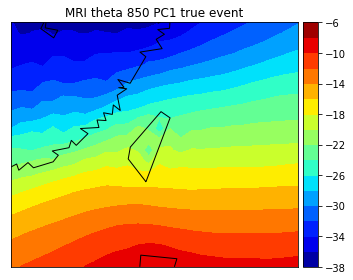

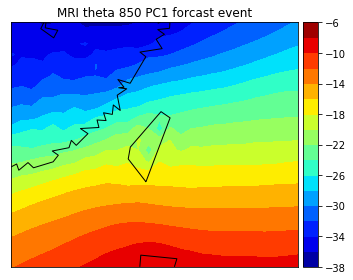

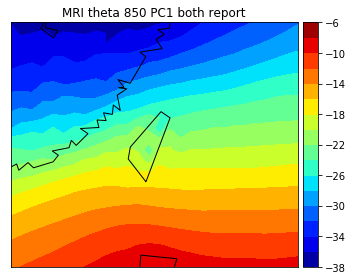

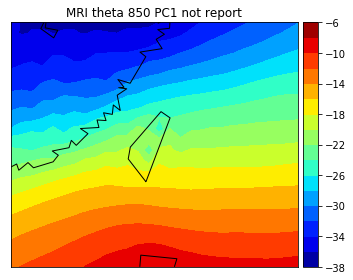

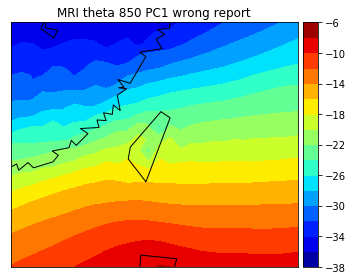

0

In [153]:
vector=mri_pca_th850[0:3642,0]
pc1map=np.empty((3642,6720))
for i in range(0,3642):
 pc1map[i,:]=vector[i,]*pca_th850.components_[0]


def show_cfsr_array(data, title=None):
    # Read data
    tmp = data
    # Create Basemap for CFSR
    lons = np.linspace(114.5, 128., num=tmp.shape[1])
    lats = np.linspace(18., 29.5, num=tmp.shape[0])
    x, y = np.meshgrid(lons,lats)
    m = Basemap(llcrnrlon=114.5, urcrnrlon=128., llcrnrlat=18., urcrnrlat=29.5)
    # draw coastlines, state and country boundaries, edge of map.
    m.drawcoastlines()
    m.contourf(x, y, tmp, 30, levels=np.linspace(-38,-6,17),cmap=plt.cm.jet)
    m.colorbar()
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    return(0)



show_cfsr_array(pc1map[Y==1,:672].mean(axis=0).reshape(24,28), 'MRI theta 850 PC1 true event')
show_cfsr_array(pc1map[ori==1,:672].mean(axis=0).reshape(24,28), 'MRI theta 850 PC1 forcast event')
show_cfsr_array(pc1map[((Y==1) & (ori==1)),:672].mean(axis=0).reshape(24,28), 'MRI theta 850 PC1 both report')
show_cfsr_array(pc1map[((Y==1) & (ori==0)),:672].mean(axis=0).reshape(24,28), 'MRI theta 850 PC1 not report')
show_cfsr_array(pc1map[((Y==0) & (ori==1)),:672].mean(axis=0).reshape(24,28), 'MRI theta 850 PC1 wrong report')


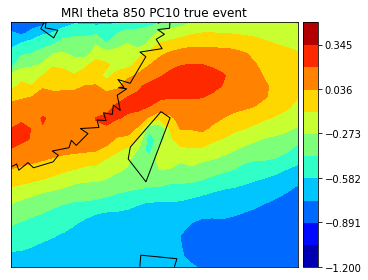

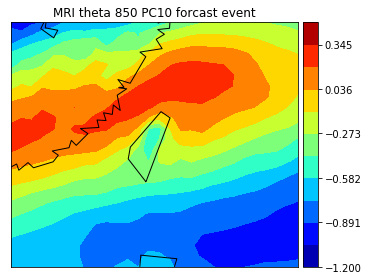

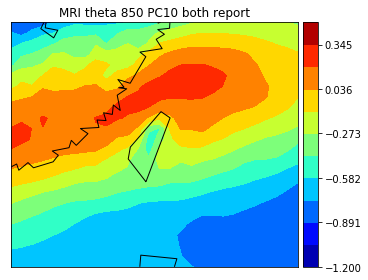

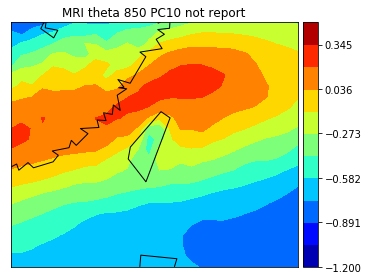

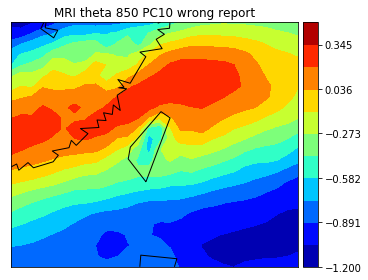

0

In [138]:
vector=mri_pca_th850[0:3642,9]
pc1map=np.empty((3642,6720))
for i in range(0,3642):
 pc1map[i,:]=vector[i,]*pca_th850.components_[9]


def show_cfsr_array(data, title=None):
    # Read data
    tmp = data
    # Create Basemap for CFSR
    lons = np.linspace(114.5, 128., num=tmp.shape[1])
    lats = np.linspace(18., 29.5, num=tmp.shape[0])
    x, y = np.meshgrid(lons,lats)
    m = Basemap(llcrnrlon=114.5, urcrnrlon=128., llcrnrlat=18., urcrnrlat=29.5)
    # draw coastlines, state and country boundaries, edge of map.
    m.drawcoastlines()
    m.contourf(x, y, tmp, 30, levels=np.linspace(-1.2,0.5,12),cmap=plt.cm.jet)
    m.colorbar()
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    return(0)



show_cfsr_array(pc1map[Y==1,:672].mean(axis=0).reshape(24,28), 'MRI theta 850 PC10 true event')
show_cfsr_array(pc1map[ori==1,:672].mean(axis=0).reshape(24,28), 'MRI theta 850 PC10 forcast event')
show_cfsr_array(pc1map[((Y==1) & (ori==1)),:672].mean(axis=0).reshape(24,28), 'MRI theta 850 PC10 both report')
show_cfsr_array(pc1map[((Y==1) & (ori==0)),:672].mean(axis=0).reshape(24,28), 'MRI theta 850 PC10 not report')
show_cfsr_array(pc1map[((Y==0) & (ori==1)),:672].mean(axis=0).reshape(24,28), 'MRI theta 850 PC10 wrong report')

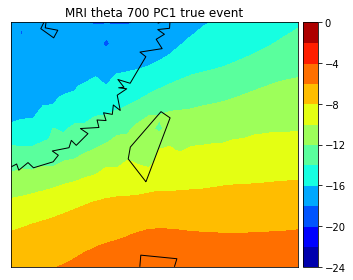

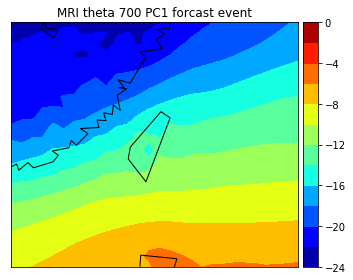

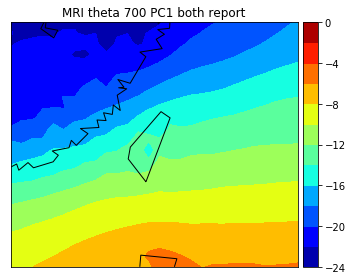

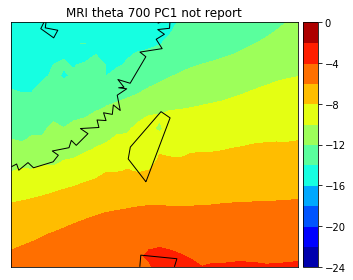

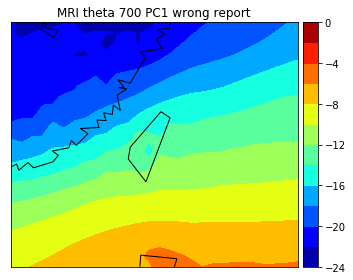

0

In [139]:
vector=mri_pca_th700[0:3642,0]
pc1map=np.empty((3642,6720))
for i in range(0,3642):
 pc1map[i,:]=vector[i,]*pca_th700.components_[0]


def show_cfsr_array(data, title=None):
    # Read data
    tmp = data
    # Create Basemap for CFSR
    lons = np.linspace(114.5, 128., num=tmp.shape[1])
    lats = np.linspace(18., 29.5, num=tmp.shape[0])
    x, y = np.meshgrid(lons,lats)
    m = Basemap(llcrnrlon=114.5, urcrnrlon=128., llcrnrlat=18., urcrnrlat=29.5)
    # draw coastlines, state and country boundaries, edge of map.
    m.drawcoastlines()
    m.contourf(x, y, tmp, 30, levels=np.linspace(-24,0,13),cmap=plt.cm.jet)
    m.colorbar()
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    return(0)



show_cfsr_array(pc1map[Y==1,:672].mean(axis=0).reshape(24,28), 'MRI theta 700 PC1 true event')
show_cfsr_array(pc1map[ori==1,:672].mean(axis=0).reshape(24,28), 'MRI theta 700 PC1 forcast event')
show_cfsr_array(pc1map[((Y==1) & (ori==1)),:672].mean(axis=0).reshape(24,28), 'MRI theta 700 PC1 both report')
show_cfsr_array(pc1map[((Y==1) & (ori==0)),:672].mean(axis=0).reshape(24,28), 'MRI theta 700 PC1 not report')
show_cfsr_array(pc1map[((Y==0) & (ori==1)),:672].mean(axis=0).reshape(24,28), 'MRI theta 700 PC1 wrong report')

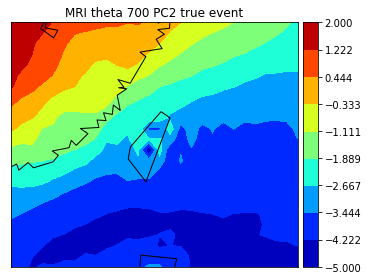

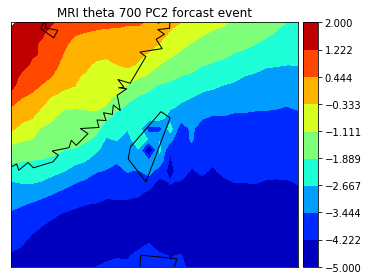

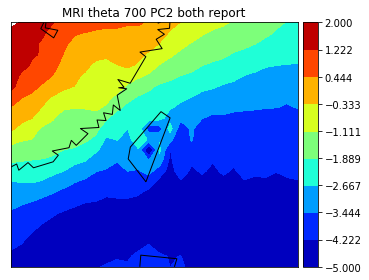

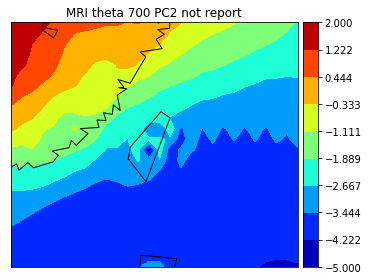

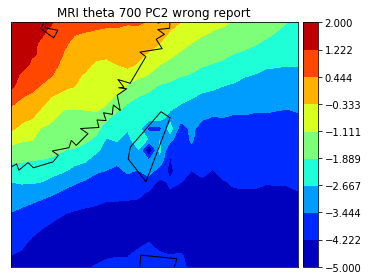

0

In [166]:
vector=mri_pca_th700[0:3642,1]
pc1map=np.empty((3642,6720))
for i in range(0,3642):
 pc1map[i,:]=vector[i,]*pca_th700.components_[1]


def show_cfsr_array(data, title=None):
    # Read data
    tmp = data
    # Create Basemap for CFSR
    lons = np.linspace(114.5, 128., num=tmp.shape[1])
    lats = np.linspace(18., 29.5, num=tmp.shape[0])
    x, y = np.meshgrid(lons,lats)
    m = Basemap(llcrnrlon=114.5, urcrnrlon=128., llcrnrlat=18., urcrnrlat=29.5)
    # draw coastlines, state and country boundaries, edge of map.
    m.drawcoastlines()
    m.contourf(x, y, tmp, 30, levels=np.linspace(-5,2,10),cmap=plt.cm.jet)
    m.colorbar()
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    return(0)



show_cfsr_array(pc1map[Y==1,:672].mean(axis=0).reshape(24,28), 'MRI theta 700 PC2 true event')
show_cfsr_array(pc1map[ori==1,:672].mean(axis=0).reshape(24,28), 'MRI theta 700 PC2 forcast event')
show_cfsr_array(pc1map[((Y==1) & (ori==1)),:672].mean(axis=0).reshape(24,28), 'MRI theta 700 PC2 both report')
show_cfsr_array(pc1map[((Y==1) & (ori==0)),:672].mean(axis=0).reshape(24,28), 'MRI theta 700 PC2 not report')
show_cfsr_array(pc1map[((Y==0) & (ori==1)),:672].mean(axis=0).reshape(24,28), 'MRI theta 700 PC2 wrong report')

In [184]:
vector=mri_pca_th700[0:3642,1]
pc1map=np.empty((3642,6720))
for i in range(0,3642):
 pc1map[i,:]=vector[i,]*pca_th700.components_[1]


def show_cfsr_array(data, title=None):
    # Read data
    plt.figure(figsize=(8,8))
    tmp = data
    # Create Basemap for CFSR
    lons = np.linspace(114.5, 128., num=tmp.shape[1])
    lats = np.linspace(18., 29.5, num=tmp.shape[0])
    x, y = np.meshgrid(lons,lats)
    m = Basemap(llcrnrlon=114.5, urcrnrlon=128., llcrnrlat=18., urcrnrlat=29.5)
    # draw coastlines, state and country boundaries, edge of map.
    m.drawcoastlines()
    m.contourf(x, y, tmp, 30, levels=np.linspace(-6,8,14),cmap=plt.cm.jet)
    m.colorbar()
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.savefig('zoutput_MRI_700_pc2_{0}.png'.format(i))
    return(0)

#for i in range(1,11):
 #   show_cfsr_array(pc1map[((Y==1) & (ori==1)),(i-1)*672:672*(i)].mean(axis=0).reshape(24,28), 'MRI theta 700 PC2 both report')
